In [11]:
import sys
sys.path.append("..")

import numpy as np
import matplotlib.pyplot as plt

from src.preprocess.polynomial import PloynomialFeature
from src.linear.linear_regression import LinearRegression
from src.linear.ridge_regression import RidgeRegression

## 1.1 多项式曲线拟合
假设我们观察到一个实值输入变量$x$，我们希望使用这个观测值去预测一个实值目标变量$t$。本示例的数据由函数$\sin {2\pi x}$生成，生成的目标值中包含随机噪声。现在假设数据集$\mathbf{x}  = \{x_1, \dots, x_N\}^T$，和相应的观测值$t$，表示为$\mathbf{t} = (t_1, \dots, t_N)^T$，下图展示了训练集的曲线图，包括了$N=10$个数据点

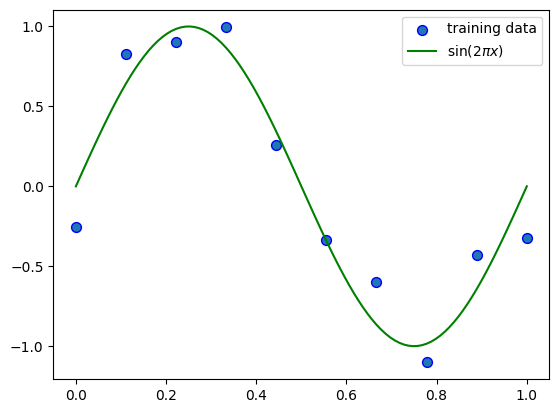

In [2]:
def create_data(func, std, size):
    #训练数据
    x = np.linspace(0, 1, size)
    t = func(x) + np.random.normal(scale=std, size=x.shape)

    return x, t

def func(x):
    return np.sin(2 * np.pi * x)

x_train, y_train = create_data(func, 0.25, 10)
x_test = np.linspace(0, 1, 100)
y_test = func(x_test)

plt.scatter(x_train, y_train, edgecolors='b', s=50,  label='training data')
plt.plot(x_test, y_test, c='g', label='$\sin(2\pi x)$')
plt.legend()
plt.show()



我们使用如下多项式
$$
y(x, \mathbf{w})=w_0 + w_1x +w_2x^2+\dots+w_Mx^M=\sum_{j=0}^Mw_jx^j
$$
其中M是多项式的阶数，可以注意到多项式是$w$的线性函数，不是$x$的，系数的值将通过多项式拟合到训练数据。这可以通过最小化误差函数完成，其中一种被广泛运用的就是均方误差
$$
E(\mathbf{w})=\frac{1}{2} \sum_{n=1}^N \{y(x_n,\mathbf{w} )-t_n\}^2
$$
我们可以通过选择是的$E(\mathbf{w})$尽可能小的$\mathbf{w}$的值来解决曲线拟合问题，因为误差函数是系数$\mathbf{w}$的二次函数，其关于系数的导数和$\mathbf{w}$呈线性关系，所以最小化误差方程有一个唯一解，用$\mathbf{w}^\star$表示。还有一个重要的内容是关于模型比较和模型选择，在下图中，我们展示了当次数选择$M=0, 1, 3 $ 和 $9$时的数据分布。

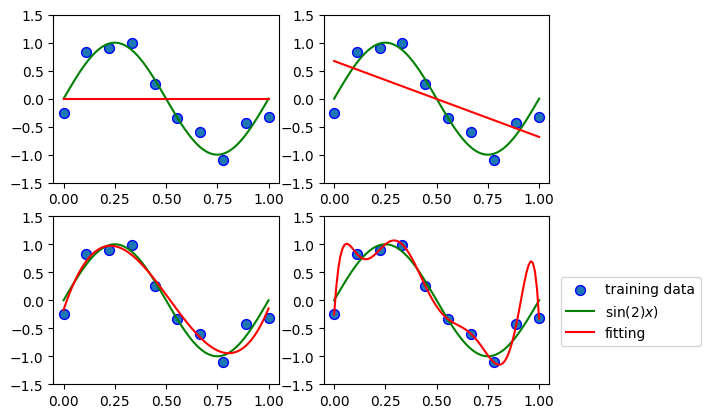

In [12]:
for i, degree in enumerate([0, 1, 3, 9]):
    plt.subplot(2, 2, i+1)
    feature = PloynomialFeature(degree)
    X_train = feature.transform(x_train)
    X_test = feature.transform(x_test)

    model = LinearRegression()
    model.fit(X_train, y_train)
    y = model.predict(X_test)

    plt.scatter(x_train, y_train, edgecolors='b', s=50, label='training data')
    plt.plot(x_test, y_test, c='g', label='$\sin(2)x)$')
    plt.plot(x_test, y, c='r', label='fitting')
    plt.ylim(-1.5, 1.5)
    plt.annotate("M={}".format(degree), xy=(-0.15, 1))
plt.legend(bbox_to_anchor=(1.05, 0.64), loc=2, borderaxespad=0.)
plt.show()

我们可以根据求的的$E(\mathbf{w}^{\star})$的残差来评估训练数据，有时候使用均方根更加方便，RMS定义为
$$
E_{RMS} = \sqrt{2E(\mathbf{w}^{\star})/N} 
$$
除以$N$可以使得我们在不同大小的数据集上公平的比较，平方根保证了$E_{RMS}$和目标变量$t$在同一个数量级，训练和测试集的误差如下图所示

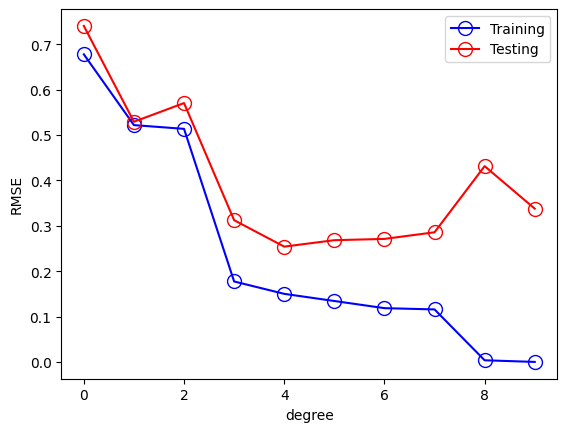

In [9]:
def rmse(a, b):
    return np.sqrt(np.mean(np.square(a - b)))

train_errors = []
test_errors = []

for i in range(10):
    feature = PloynomialFeature(i)
    X_train = feature.transform(x_train)
    X_test = feature.transform(x_test)

    model = LinearRegression()
    model.fit(X_train, y_train)

    y = model.predict(X_test)
    train_errors.append(rmse(model.predict(X_train), y_train))
    test_errors.append(rmse(model.predict(X_test), y_test + np.random.normal(scale=0.25, size=len(y_test))))

plt.plot(train_errors, 'o-', mfc="none", mec="b", ms=10, c="b", label="Training")
plt.plot(test_errors, 'o-', mfc="none", mec="r", ms=10, c="r", label="Testing")
plt.legend()
plt.xlabel("degree")
plt.ylabel("RMSE")
plt.show()

一个被用于控制过拟合现象的技术就是正则化，最简单的惩罚项就是所有系数的平方和
$$
\widetilde{E}(\mathbf{w} )=\frac{1}{2} \sum_{n=1}^{N} \{y(x_n, \mathbf{w} ) - t_n\}^2 + 
\frac{\lambda }{2} \left \| \mathbf{w}  \right \| ^2
$$
系数$\lambda$控制了正则化项和平方和误差的相对重要性。我们经常可以发现$w_0$在正则化项中被省略，这是因为包含它会导致结果取决于目标变量的原点选择。下图展示了选择不同的$\lambda$的值时，对多项式拟合的影响。

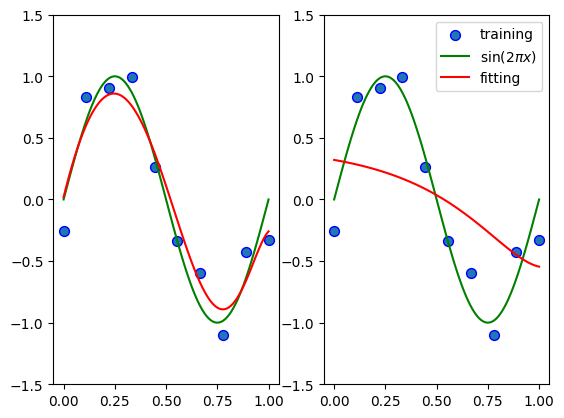

In [13]:
for i, alp in enumerate([1e-3, 1]):
    plt.subplot(1, 2, i+1)
    feature = PloynomialFeature(9)
    X_train = feature.transform(x_train)
    X_test = feature.transform(x_test)

    model = RidgeRegression(alpha=alp)
    model.fit(X_train, y_train)

    y = model.predict(X_test)
    plt.scatter(x_train, y_train, edgecolors='b', s=50, label='training')
    plt.plot(x_test, y_test, c='g', label='$\sin(2\pi x)$')
    plt.plot(x_test, y, c='r', label='fitting')
    plt.ylim(-1.5, 1.5)
plt.legend()
plt.annotate("M=9", xy=(-0.15, 1))
plt.show()

# 概率理论
